# 25-D Correlated Normal

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems (with or without the use of gradients). Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems using a 25-D correlated multivariate normal distribution.

In [4]:
ndim = 25  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.4  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# gradient of log-likelihood *with respect to u*
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 10.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-57.56461299227203


Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                nlive=500, bound='single', 
                                sample='slice', slices=5)
sampler.run_nested(dlogz=0.01)
res = sampler.results

iter: 20857 | +500 | bound: 203 | nc: 1 | ncall: 12125119 | eff(%):  0.176 | loglstar:   -inf < -20.270 <    inf | logz: -57.340 +/-  0.232 | dlogz:  0.000 >  0.010                                  

In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single', 
                                sample='rslice', slices=25)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

iter: 20498 | +500 | bound: 95 | nc: 1 | ncall: 2400043 | eff(%):  0.875 | loglstar:   -inf < -20.757 <    inf | logz: -57.108 +/-  0.232 | dlogz:  0.000 >  0.010                                    

In [7]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single',
                                sample='hslice', slices=5,
                                gradient=gradient)
sampler.run_nested(dlogz=0.01)
res3 = sampler.results

iter: 20810 | +500 | bound: 277 | nc: 1 | ncall: 17454355 | eff(%):  0.122 | loglstar:   -inf < -20.734 <    inf | logz: -57.709 +/-  0.234 | dlogz:  0.000 >  0.010                                  

Now let's see how we do.

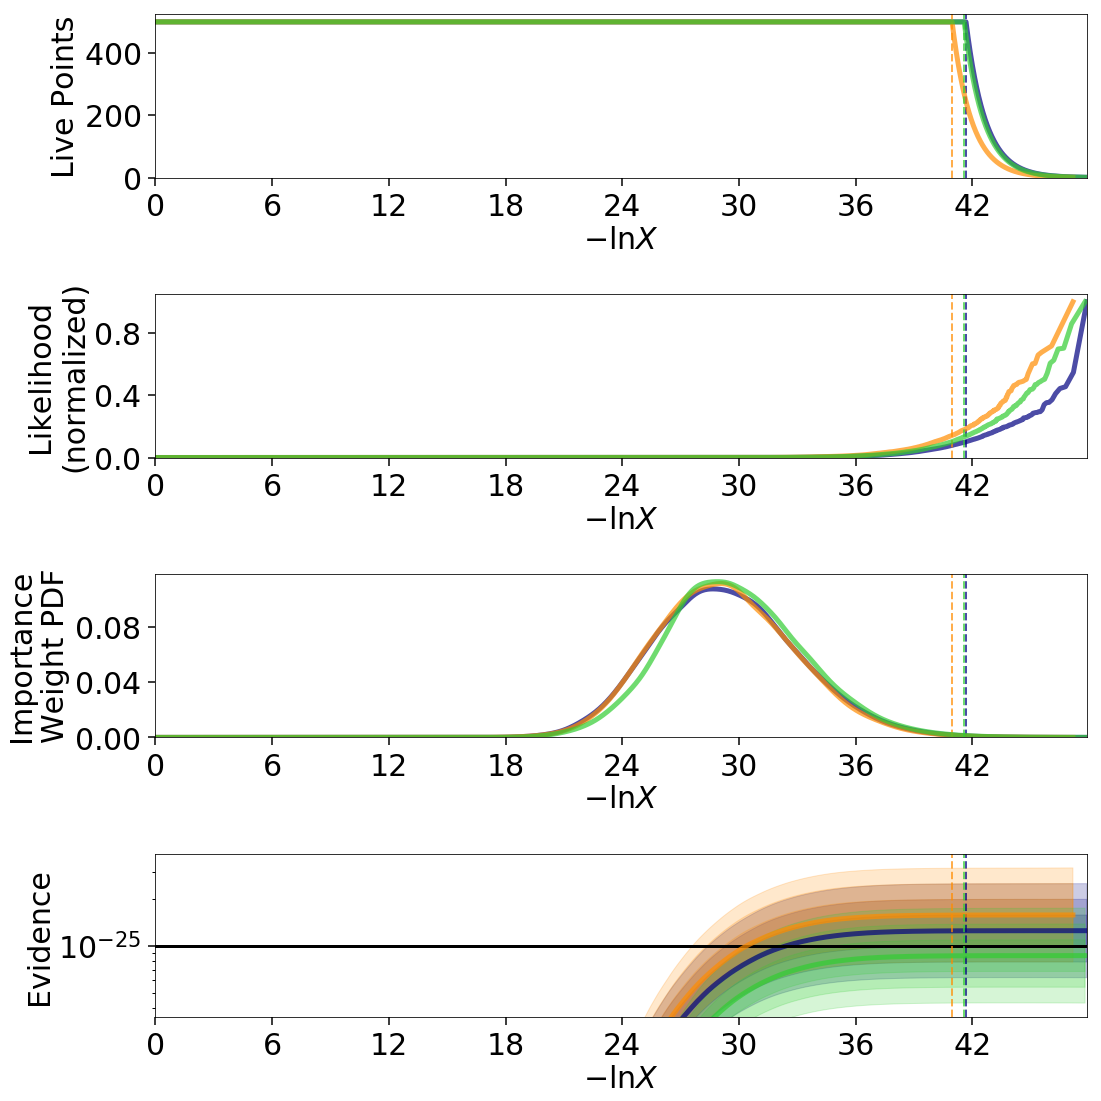

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='navy', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='darkorange', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()

In [9]:
from dynesty import utils as dyfunc

print('Mean:')
print('slice:', dyfunc.mean_and_cov(res.samples, 
                                    np.exp(res.logwt-res.logz[-1]))[0])
print('rslice:', dyfunc.mean_and_cov(res2.samples, 
                                     np.exp(res2.logwt-res2.logz[-1]))[0])
print('hslice:', dyfunc.mean_and_cov(res3.samples, 
                                     np.exp(res3.logwt-res3.logz[-1]))[0])

print('\nVariance:')
print('slice:', np.diagonal(dyfunc.mean_and_cov(res.samples, 
                                                np.exp(res.logwt-res.logz[-1]))[1]))
print('rslice:', np.diagonal(dyfunc.mean_and_cov(res2.samples, 
                                                 np.exp(res2.logwt-res2.logz[-1]))[1]))
print('hslice:', np.diagonal(dyfunc.mean_and_cov(res3.samples, 
                                                 np.exp(res3.logwt-res3.logz[-1]))[1]))

Mean:
slice: [ 0.00464139  0.01779515 -0.00059102  0.01545529  0.00196981 -0.01102295
  0.0224263   0.00128731  0.0165881   0.01004745  0.02403447  0.02490094
  0.02634624  0.0221378   0.01095415  0.01451562  0.00810768  0.0186859
  0.01441112  0.0142988   0.00562206  0.01013293  0.03261655  0.01514425
 -0.00096744]
rslice: [-0.01262438 -0.02215703 -0.02894398  0.00412    -0.01239199  0.00537269
 -0.00883646 -0.01124688 -0.00622417 -0.02345228 -0.01226172 -0.01741414
 -0.00340907 -0.02107367 -0.0440053  -0.00461723  0.00210266 -0.00553831
 -0.0342508  -0.04259448 -0.03088255  0.00615101 -0.00708561 -0.01839912
 -0.01779207]
hslice: [-0.00770402 -0.02471443 -0.042487   -0.01095513 -0.03419283 -0.01587577
 -0.0073069  -0.01633131 -0.01914578 -0.02243197 -0.01922804 -0.03532052
 -0.0229837  -0.02118347 -0.00624797 -0.02247772 -0.02899336 -0.02943324
 -0.02318504 -0.02445557 -0.02455501 -0.00661906 -0.029969   -0.01755215
 -0.01973601]

Variance:
slice: [0.99505849 0.97200556 1.03652393 0.